Name: Larissa Huang (Brainstation Data Science Diploma Candidate) <br>
Contact: lari.huang@gmail.com

# Duck Duck Choose: Pecking at Pixels with Machine Learning 
### Sprint 2

## Table of Contents
- [Data Dictionary](#Data-Dictionary)
- [Data Cleaning](#Data-Cleaning)
- [EDA](#EDA)
- [Plotting Distribution of Image Counts](#plotting_distribution)
- [Encoding an Image as an Array](#encoding_image)
- [Merging Species into Genus](#merging_species)
- [Adding Genus to Dataframes](#adding_genus)
- [CNN Base Model](#cnn_base_model)
- [Image Preprocessing](#image_preprocessing)
- [Label Encoding for y-values](#label_encoding)
- [Building CNN Model Architecture](#building_cnn)
- [Train the Model](#train_model)
- [Visualize Our Classes](#visualize_our_classes)
- [Evaluate Model's Performance on Valid Data](#evaluate_performance_valid)
- [Evaluate the Model's Performance on the Test Data](#evaluate_performance_test)
- [Base CNN Model Conclusion](#base_cnn_conc)
- [Next Steps](#next_steps)


In [275]:
# import relevant packages
import numpy as np
import pandas as pd

# import for plotting
import matplotlib.pyplot as plt

# import to display images
from IPython.display import Image, display

# import to get image array
import cv2

# import to navigate file system and copy images
import os
import shutil

# import label encoder
from sklearn.preprocessing import LabelEncoder

# import image data generator to preload images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# import for model to have random seeds for reproducability
import random

# import tensorflow
import tensorflow as tf

# import specific neural network models & layer types
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

#suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [276]:
# print working directory
print(os.getcwd())

/Users/larissahuang/mygitrepo


In [277]:
# change new_directory to your directory
new_directory = '/Users/larissahuang/mygitrepo'
os.chdir(new_directory)

In [278]:
# load in data
df = pd.read_csv('birds.csv')

# take a look at data
df.head()

,class id,filepaths,labels,data set,scientific name
0,0.0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0.0,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0.0,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0.0,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0.0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI


## Data Dictionary

<table>
  <tr>
    <th style="text-align: left; background: lightgrey">Column Name</th>
    <th style="text-align: left; background: lightgrey">Description</th>
  </tr>
  <tr>
    <td style="text-align: left"> <code>labels</code> </td>
    <td style="text-align: left">bird species associated with the image file</td>
  </tr>
    <tr>
    <td style="text-align: left"><code>scientific label</code></td>
    <td style="text-align: left">scientific name for the bird species</td>
  </tr>
  <tr>
    <td style="text-align: left"><code>filepaths</code></td>
    <td style="text-align: left">the relative file path to an image file</td>
  </tr>
    <tr>
    <td style="text-align: left"><code>data set</code></td>
    <td style="text-align: left">which dataset (train, test or valid) the image filepath belongs to</td>
  </tr>
      <tr>
    <td style="text-align: left"><code>data set</code></td>
    <td style="text-align: left">which dataset (train, test or valid) the image filepath belongs to</td>
  </tr>
       <tr>
    <td style="text-align: left"><code>class_id</code></td>
    <td style="text-align: left">the class index value associated with the image file's class</td>
  </tr>

</table>

## Data Cleaning

We can see that the dataframe has 4 features of significance: the filepath to the image, the labels which represents the species, the dataset it belongs to, and the scientific name of the species. The class id column contains no relevant information so I will drop it. I will also rename "labels" to "species" because it's more descriptive, and drop the scientific name as the species enough. I will also rename "filepaths" to "path". 

In [279]:
# drop class id
df.drop('class id', axis=1, inplace=True)

# rename labels to species
df.rename(columns={'labels': 'species'}, inplace=True)

# drop scientific name column
df.drop('scientific name', axis=1, inplace=True)

# rename filepaths to path
df.rename(columns={'filepaths': 'path'}, inplace=True)

I will be doing the same proprocessing steps for the train, validation and test data sets. To avoid data leakage, I will separate them into their respective dataframes and do further processing separately. 

In [280]:
df_train = df[(df["data set"] == "train")]
df_valid = df[(df["data set"] == "valid")]
df_test = df[(df["data set"] == "test")]

In [281]:
print(f'Train set length: {len(df_train)}, Validation set length: {len(df_valid)}, Test set length: {len(df_test)}')

Train set length: 84635, Validation set length: 2625, Test set length: 2625


For all 525 species, the training set has 84635 images, and the validation and the test set have 2625. Now let's look into the image data further.

In [282]:
# Find the minimum count of any 'species' in the df_train DataFrame
min_count = df_train['species'].value_counts().min()

# Calculate the mean count of 'species' across the df_train DataFrame
mean_count = df_train['species'].value_counts().mean()

# Round the mean count to the nearest whole number for readability
mean_count = round(mean_count)

# Find the maximum count of any 'species' in the df_train DataFrame
max_count = df_train['species'].value_counts().max()

print(f"min count: {min_count}")
print(f"mean count: {mean_count}")
print(f"max count: {max_count}")

min count: 130
mean count: 161
max count: 263


In [283]:
# Group df_train by 'species', count the occurrences of each species in the path column
# reset the index to turn the series into a df and rename the count column to 'count'.
# sort the resulting df by the 'count' column in descending order.
df_species_count = df_train.groupby('species')['path'].count().reset_index(name='count').sort_values(by='count', ascending=False)

# show df that contains the species and their respective counts, sorted from the most to the least common.
df_species_count

,species,count
434,RUFOUS TREPE,263
291,HOUSE FINCH,248
374,OVENBIRD,233
184,D-ARNAUDS BARBET,233
41,ASIAN GREEN BEE EATER,220
...,...,...
416,RED TAILED THRUSH,130
363,NORTHERN RED BISHOP,130
25,AMETHYST WOODSTAR,130
382,PATAGONIAN SIERRA FINCH,130


## Findings from above:
For the training set, the min count of images for each species is 130, the mean count is 161 and the max count is 263. This isn't a lot of images to work with. Out of 525 species, species with the most numerous image is the Rufous Trepe, with 263 images. This number is insufficient for training a CNN on, so I'll do some further processing before we get to training the model.

## 
Now that we have data separately into train, valid and test sets, we can drop the "data set" column from each of them. 

In [284]:
# now that each dataframe only has data for one dataset, we can drop the data set column
df_train.drop('data set', axis=1, inplace=True)
df_valid.drop('data set', axis=1, inplace=True)
df_test.drop('data set', axis=1, inplace=True)

#taking a look at df_train
df_train

,path,species
0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER
1,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER
2,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER
3,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER
4,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER
...,...,...
84630,train/BLACK BREASTED PUFFBIRD/151.jpg,BLACK BREASTED PUFFBIRD
84631,train/BLACK BREASTED PUFFBIRD/152.jpg,BLACK BREASTED PUFFBIRD
84632,train/BLACK BREASTED PUFFBIRD/153.jpg,BLACK BREASTED PUFFBIRD
84633,train/BLACK BREASTED PUFFBIRD/146.jpg,BLACK BREASTED PUFFBIRD


In [285]:
# Count the occurrences of each unique value in the column
df_grouped = df_train.groupby(['species']).count()

df_grouped


,path
species,
ABBOTTS BABBLER,163
ABBOTTS BOOBY,180
ABYSSINIAN GROUND HORNBILL,179
AFRICAN CROWNED CRANE,135
AFRICAN EMERALD CUCKOO,154
...,...
YELLOW BELLIED FLOWERPECKER,154
YELLOW BREASTED CHAT,202
YELLOW CACIQUE,155


## EDA

<a id='plotting_distribution'></a>
## Plotting Distribution of Image Counts

In [286]:
# copying image counts into new df
img_counts = sorted_grouped_df.copy()

# reset index on new df
img_counts = img_counts.reset_index(drop=True)

species_counts = img_counts["count"]

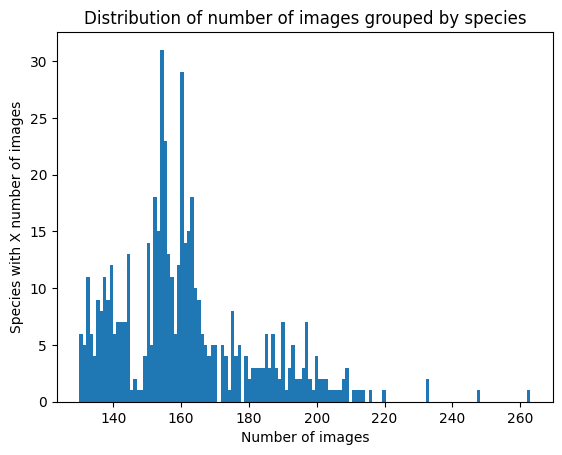

In [287]:
## plotting the distribution of images across all species to determine which counts are commo
plt.figure()

# bins set to 134 because that is the range between min and max count
plt.hist(species_counts, bins = 134)

plt.title('Distribution of number of images grouped by species')

plt.xlabel('Number of images')

plt.ylabel('Species with X number of images')
plt.show()

### Findings from above: 
This histogram shows that the vast majority of species have fewer than 200 images and there are many species with 150-170 images.  

Now let's take a look at some photos for the species with the least number of photos. We learned above that the least number of photos is 130, and the following species are tied for least number of photos. 

<a id='encoding_image'></a>
## Encoding an image as an array

As a test, I will encode a single image as an array. I will be reusing this code block and using it to preprocess all images for my CNN later.

In [292]:
#saving the path to this particiular image as image_path
image_path = 'train/AMETHYST WOODSTAR/018.jpg'

#using cv2.imread to reaod the image_path as an array, and saving it to image
image = cv2.imread(image_path)

# Check if the image is loaded correctly
if image is not None:
    print("Image loaded successfully")
    # Image is already an array
    print(type(image))
    print("Shape:", image.shape)  

    # Accessing a pixel value
    pixel_value = image[20, 10]
    print("Pixel value (BGR):", pixel_value)
else:
    print("Failed to load the image")

Image loaded successfully
<class 'numpy.ndarray'>
Shape: (224, 224, 3)
Pixel value (BGR): [ 96 168 175]


In [293]:
# printing the image array
image

array([[[ 95, 165, 172],
        [ 95, 165, 172],
        [ 95, 165, 172],
        ...,
        [143, 189, 200],
        [143, 189, 200],
        [143, 189, 200]],

       [[ 95, 165, 172],
        [ 95, 165, 172],
        [ 95, 165, 172],
        ...,
        [143, 189, 200],
        [143, 189, 200],
        [143, 189, 200]],

       [[ 95, 165, 172],
        [ 95, 165, 172],
        [ 95, 165, 172],
        ...,
        [143, 189, 200],
        [143, 189, 200],
        [143, 189, 200]],

       ...,

       [[ 94, 137, 140],
        [ 94, 137, 140],
        [ 94, 137, 140],
        ...,
        [126, 165, 174],
        [126, 165, 174],
        [126, 165, 174]],

       [[ 93, 136, 139],
        [ 93, 136, 139],
        [ 93, 136, 139],
        ...,
        [125, 164, 173],
        [126, 165, 174],
        [125, 164, 173]],

       [[ 92, 135, 138],
        [ 92, 135, 138],
        [ 93, 136, 139],
        ...,
        [125, 164, 173],
        [125, 164, 173],
        [125, 164, 173]]

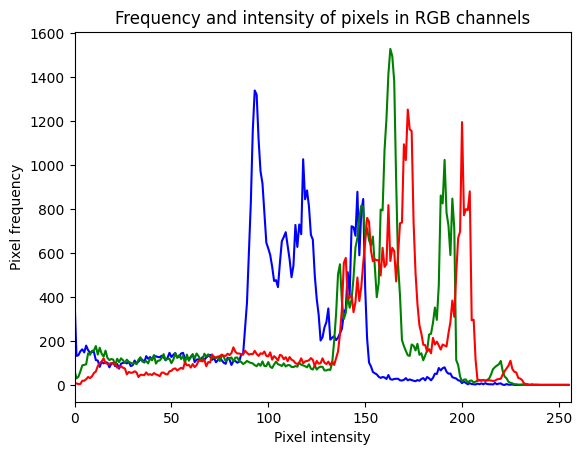

In [294]:
# find frequency and intensity value for each pixel in the loaded image
for i, col in enumerate(['b', 'g', 'r']):
    hist = cv2.calcHist([image], [i], None, [256], [0, 256])
    plt.plot(hist, color = col)
    plt.title("Frequency and intensity of pixels in RGB channels")
    plt.ylabel("Pixel frequency")
    plt.xlabel("Pixel intensity")
    plt.xlim([0, 256])

    
plt.show()

## Findings from above: 
The x-axis is the brightness of the pixel where 0 → Black | 255 → White. The y-axis is the frequency of occurence in the image. A higher peak means more of that RGB channel.

The above was part of my preliminary image analysis before deciding to use a CNN model. For a CNN model, the comparison of images by their RGB channels is not necessary, so the above plot is for explorative purposes only and will not be used in the next sections

<a id='merging_species'></a>
## Merging Species into Genus

Because we have such a low number of images for each species, I decided to combine species into their genus and use genus as a category. That way, I'd have more data per category. My methodology for this would be to get the last word of each species, since in the vast majority of cases, this would indicate the genus name. Example: Cerulean Warbler is of the genus Warbler. From a visual overview of the folder names, the bird names that do not follow this convention are extremely rare. Since I will end up dropping all but the top genera in terms of image counts of all their constituent species, the rare cases are not relevant. 

In [295]:
# merging dataframes with image counts to preserve the path and species of each bird before we add genus
df_train = pd.merge(df_train, img_counts, on='species', how='left')
df_valid =  pd.merge(df_valid, img_counts, on='species', how='left')
df_test =  pd.merge(df_test, img_counts, on='species', how='left')

In [296]:
# getting the last word from the species name
last_words = df_train['species'].apply(lambda x: x.split()[-1])

# gebt unibque last words
unique_last_words = last_words.unique()

# printing the unique last words
unique_last_words

array(['BABBLER', 'BOOBY', 'HORNBILL', 'CRANE', 'CUCKOO', 'FIREFINCH',
       'CATCHER', 'GOOSE', 'ALBATROSS', 'TOWHEE', 'PARAKEET', 'CHOUGH',
       'YELLOWTHROAT', 'AVOCET', 'BITTERN', 'COOT', 'FLAMINGO',
       'GOLDFINCH', 'KESTREL', 'PIPIT', 'REDSTART', 'ROBIN', 'WIGEON',
       'WOODSTAR', 'LAPWING', 'SISKIN', 'ANHINGA', 'ANIANIAU',
       'HUMMINGBIRD', 'ANTBIRD', 'EUPHONIA', 'APAPANE', 'APOSTLEBIRD',
       'MANAKIN', 'PETREL', 'THRUSHBIRD', 'IBIS', 'BIRD', 'EATER',
       'STORK', 'SHAQ', 'CANASTERO', 'FIGBIRD', 'AVADAVAT', 'SPINETAIL',
       'PITTA', 'JAY', 'TANAGER', 'TIT', 'TEAL', 'EAGLE', 'STARLING',
       'ORIOLE', 'BANANAQUIT', 'GUAN', 'BROADBILL', 'PITA', 'STILT',
       'GODWIT', 'OWL', 'SWALLOW', 'PUFFBIRD', 'GOLDENEYE', 'WARBLER',
       'BARBET', 'BELLBIRD', 'REEDLING', 'KINGFISHER', 'PARADISE', 'BAZA',
       'COCKATO', 'SPOONBILL', 'FRANCOLIN', 'CAIQUE', 'SKIMMER', 'SWAN',
       'CRAKE', 'BUSHTIT', 'HUET', 'SHEARWATER', 'VULTURE', 'CHICKADEE',
       'GREBE', '

In [297]:
# finding the length of the unique_last_words array
unique_last_words = pd.DataFrame(unique_last_words)
len(unique_last_words)

312

## Findings from above: 
As you can see, the genus names can be derived with fantastic accuracy using this technique. As mentioned earlier, only the top few genera will be used so the inaccuracies will not factor into the model training. 

<a id='adding_genus'></a>
## Adding Genus to Dataframes
Creating a new column "genus" with the last word from the species and adding it to our original dataframes.

In [298]:
# create a new column with genus name for each dataset
df_train['genus'] = df_train['species'].apply(lambda x: x.split()[-1])
df_valid['genus'] = df_valid['species'].apply(lambda x: x.split()[-1])
df_test['genus'] = df_test['species'].apply(lambda x: x.split()[-1])

In [299]:
# checking df_train
df_train

,path,species,count,genus
0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,163,BABBLER
1,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,163,BABBLER
2,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,163,BABBLER
3,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,163,BABBLER
4,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,163,BABBLER
...,...,...,...,...
84630,train/BLACK BREASTED PUFFBIRD/151.jpg,BLACK BREASTED PUFFBIRD,172,PUFFBIRD
84631,train/BLACK BREASTED PUFFBIRD/152.jpg,BLACK BREASTED PUFFBIRD,172,PUFFBIRD
84632,train/BLACK BREASTED PUFFBIRD/153.jpg,BLACK BREASTED PUFFBIRD,172,PUFFBIRD
84633,train/BLACK BREASTED PUFFBIRD/146.jpg,BLACK BREASTED PUFFBIRD,172,PUFFBIRD


### Next up is finding out how many images are now in each genus, and which genera are at the top

In [300]:
# Group by the last word, then aggregate only the 'count' column by summing
aggregated_df_train = df_train.groupby('genus')['count'].count().reset_index()

# Display the aggregated df
sorted_df_train = aggregated_df_train.sort_values(by='count', ascending=False)

# Display the sorted df
sorted_df_train.head(10)

,genus,count
91,DUCK,1510
298,WARBLER,1391
217,PHEASANT,1303
161,KINGFISHER,1298
93,EAGLE,1179
102,FINCH,970
123,GOOSE,962
41,BUNTING,952
204,OWL,923
270,TANAGER,921


In [301]:
# copying genus image counts into new df
genus_counts = sorted_df_train.copy()

# reset index on new df
genus_counts = genus_counts.reset_index(drop=True)

genus_counts = genus_counts["count"]

### Distribution of number of images grouped by genus

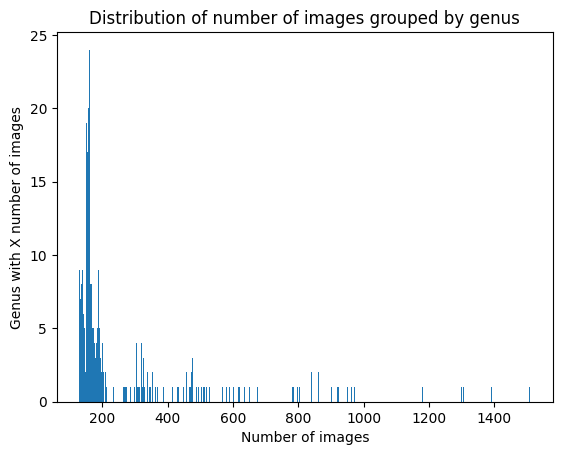

In [302]:

## plotting the distribution of images across all genera 
plt.figure()

# bins set to 134 because that is the range between min and max count
plt.hist(genus_counts, bins = 500)

plt.title('Distribution of number of images grouped by genus')

plt.xlabel('Number of images')

plt.ylabel('Genus with X number of images')
plt.show()

## Findings from above: 
By merging species into genera, we have increased our image counts per category almost tenfold. In addition, I will drop all genera with fewer than 1000 training images, using only DUCK, WARBLER, PHEASANT, KINGFISHER, and EAGLE for the first iteration of my CNN. This will make our model more accurate. 

In the future, leveraging the power of Transfer Learning using EfficientNet, I may include the other genera as well. 

In [303]:
# setting the genus values to keep
values_to_keep = ['DUCK', 'WARBLER', 'PHEASANT', 'KINGFISHER', 'EAGLE']

# modifying our dataframes to include only our top 5 genera
df_train = df_train[df_train['genus'].isin(values_to_keep)]
df_valid = df_valid[df_valid['genus'].isin(values_to_keep)]
df_test = df_test[df_test['genus'].isin(values_to_keep)]

In [304]:
# checking our dataframe
df_train

,path,species,count,genus
8257,train/BALD EAGLE/072.jpg,BALD EAGLE,160,EAGLE
8258,train/BALD EAGLE/007.jpg,BALD EAGLE,160,EAGLE
8259,train/BALD EAGLE/002.jpg,BALD EAGLE,160,EAGLE
8260,train/BALD EAGLE/004.jpg,BALD EAGLE,160,EAGLE
8261,train/BALD EAGLE/005.jpg,BALD EAGLE,160,EAGLE
...,...,...,...,...
84259,train/KNOB BILLED DUCK/164.jpg,KNOB BILLED DUCK,197,DUCK
84260,train/KNOB BILLED DUCK/158.jpg,KNOB BILLED DUCK,197,DUCK
84261,train/KNOB BILLED DUCK/157.jpg,KNOB BILLED DUCK,197,DUCK
84262,train/KNOB BILLED DUCK/156.jpg,KNOB BILLED DUCK,197,DUCK


#### We know have 6681 rows in the new dataframe, which is the sum of all the image counts for the selected genera: 'DUCK', 'WARBLER', 'PHEASANT', 'KINGFISHER', 'EAGLE'. 

In [305]:
# seeing how many species each species contributes to the genus count
df_train.groupby("genus")["species"].value_counts()

genus       species                
DUCK        WOOD DUCK                  214
            KNOB BILLED DUCK           197
            SPOTTED WHISTLING DUCK     184
            RED HEADED DUCK            160
            STEAMER DUCK               160
            TEAL DUCK                  155
            MANDRIN DUCK               154
            HARLEQUIN DUCK             151
            MALLARD DUCK               135
EAGLE       ORNATE HAWK EAGLE          208
            CRESTED SERPENT EAGLE      181
            HARPY EAGLE                175
            BALD EAGLE                 160
            GOLDEN EAGLE               158
            PHILIPPINE EAGLE           154
            GREY HEADED FISH EAGLE     143
KINGFISHER  WOODLAND KINGFISHER        194
            PYGMY KINGFISHER           173
            CRESTED KINGFISHER         163
            MALACHITE KINGFISHER       163
            RUDY KINGFISHER            160
            RUFOUS KINGFISHER          156
            BELTED

## Changing folder structure to reflect dataframe changes

We derived the genera from the species names and added a new column "genus", which we intend to be our classification categories, so now we have to save species into new folders with the name of the genus they belong to. To avoid file mixup, I will do this process separately for each of our datasets: train, valid, and test.

### Train set genus folders

In [306]:

# change this to the file where you want the genus-separated images to get sent to
base_destination_dir = '/Users/larissahuang/mygitrepo/train-genus'

for index, row in df_train.iterrows():
    genus = row['genus']
    species = row['species']
    # source file path
    source_file_path = row['path'] 

    # destination directory for this genus
    destination_dir = os.path.join(base_destination_dir, genus)

    # create the genus directory if it doesn't exist
    os.makedirs(destination_dir, exist_ok=True)

    # set destination file name
    destination_file_name = f"{species}_{os.path.basename(source_file_path)}"

    # destination path for this species' data
    species_file_path = os.path.join(destination_dir, destination_file_name)

    # Copy the file from the source to the destination
    shutil.copy(source_file_path, species_file_path)
    print(f'Copied {source_file_path} to {species_file_path}')

Copied train/BALD EAGLE/072.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/BALD EAGLE_072.jpg
Copied train/BALD EAGLE/007.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/BALD EAGLE_007.jpg
Copied train/BALD EAGLE/002.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/BALD EAGLE_002.jpg
Copied train/BALD EAGLE/004.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/BALD EAGLE_004.jpg
Copied train/BALD EAGLE/005.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/BALD EAGLE_005.jpg
Copied train/BALD EAGLE/006.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/BALD EAGLE_006.jpg
Copied train/BALD EAGLE/081.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/BALD EAGLE_081.jpg
Copied train/BALD EAGLE/009.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/BALD EAGLE_009.jpg
Copied train/BALD EAGLE/013.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/BALD EAGLE_013.jpg
Copied train/BALD EAGLE/011.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE

Copied train/BLACK THROATED WARBLER/085.jpg to /Users/larissahuang/mygitrepo/train-genus/WARBLER/BLACK THROATED WARBLER_085.jpg
Copied train/BLACK THROATED WARBLER/013.jpg to /Users/larissahuang/mygitrepo/train-genus/WARBLER/BLACK THROATED WARBLER_013.jpg
Copied train/BLACK THROATED WARBLER/054.jpg to /Users/larissahuang/mygitrepo/train-genus/WARBLER/BLACK THROATED WARBLER_054.jpg
Copied train/BLACK THROATED WARBLER/053.jpg to /Users/larissahuang/mygitrepo/train-genus/WARBLER/BLACK THROATED WARBLER_053.jpg
Copied train/BLACK THROATED WARBLER/035.jpg to /Users/larissahuang/mygitrepo/train-genus/WARBLER/BLACK THROATED WARBLER_035.jpg
Copied train/BLACK THROATED WARBLER/058.jpg to /Users/larissahuang/mygitrepo/train-genus/WARBLER/BLACK THROATED WARBLER_058.jpg
Copied train/BLACK THROATED WARBLER/052.jpg to /Users/larissahuang/mygitrepo/train-genus/WARBLER/BLACK THROATED WARBLER_052.jpg
Copied train/BLACK THROATED WARBLER/012.jpg to /Users/larissahuang/mygitrepo/train-genus/WARBLER/BLACK T

Copied train/BORNEAN PHEASANT/078.jpg to /Users/larissahuang/mygitrepo/train-genus/PHEASANT/BORNEAN PHEASANT_078.jpg
Copied train/BORNEAN PHEASANT/150.jpg to /Users/larissahuang/mygitrepo/train-genus/PHEASANT/BORNEAN PHEASANT_150.jpg
Copied train/BORNEAN PHEASANT/144.jpg to /Users/larissahuang/mygitrepo/train-genus/PHEASANT/BORNEAN PHEASANT_144.jpg
Copied train/BORNEAN PHEASANT/077.jpg to /Users/larissahuang/mygitrepo/train-genus/PHEASANT/BORNEAN PHEASANT_077.jpg
Copied train/BORNEAN PHEASANT/149.jpg to /Users/larissahuang/mygitrepo/train-genus/PHEASANT/BORNEAN PHEASANT_149.jpg
Copied train/BORNEAN PHEASANT/127.jpg to /Users/larissahuang/mygitrepo/train-genus/PHEASANT/BORNEAN PHEASANT_127.jpg
Copied train/BORNEAN PHEASANT/151.jpg to /Users/larissahuang/mygitrepo/train-genus/PHEASANT/BORNEAN PHEASANT_151.jpg
Copied train/BORNEAN PHEASANT/128.jpg to /Users/larissahuang/mygitrepo/train-genus/PHEASANT/BORNEAN PHEASANT_128.jpg
Copied train/BORNEAN PHEASANT/137.jpg to /Users/larissahuang/myg

Copied train/CRESTED SERPENT EAGLE/024.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/CRESTED SERPENT EAGLE_024.jpg
Copied train/CRESTED SERPENT EAGLE/030.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/CRESTED SERPENT EAGLE_030.jpg
Copied train/CRESTED SERPENT EAGLE/031.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/CRESTED SERPENT EAGLE_031.jpg
Copied train/CRESTED SERPENT EAGLE/089.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/CRESTED SERPENT EAGLE_089.jpg
Copied train/CRESTED SERPENT EAGLE/033.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/CRESTED SERPENT EAGLE_033.jpg
Copied train/CRESTED SERPENT EAGLE/034.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/CRESTED SERPENT EAGLE_034.jpg
Copied train/CRESTED SERPENT EAGLE/035.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/CRESTED SERPENT EAGLE_035.jpg
Copied train/CRESTED SERPENT EAGLE/036.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/CRESTED SERPENT EAGLE_036.jpg
Copied t

Copied train/GOLDEN EAGLE/008.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/GOLDEN EAGLE_008.jpg
Copied train/GOLDEN EAGLE/027.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/GOLDEN EAGLE_027.jpg
Copied train/GOLDEN EAGLE/041.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/GOLDEN EAGLE_041.jpg
Copied train/GOLDEN EAGLE/050.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/GOLDEN EAGLE_050.jpg
Copied train/GOLDEN EAGLE/010.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/GOLDEN EAGLE_010.jpg
Copied train/GOLDEN EAGLE/038.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/GOLDEN EAGLE_038.jpg
Copied train/GOLDEN EAGLE/017.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/GOLDEN EAGLE_017.jpg
Copied train/GOLDEN EAGLE/029.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/GOLDEN EAGLE_029.jpg
Copied train/GOLDEN EAGLE/018.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/GOLDEN EAGLE_018.jpg
Copied train/GOLDEN EAGLE/033.jpg to /Users/la

Copied train/HARPY EAGLE/063.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/HARPY EAGLE_063.jpg
Copied train/HARPY EAGLE/051.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/HARPY EAGLE_051.jpg
Copied train/HARPY EAGLE/045.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/HARPY EAGLE_045.jpg
Copied train/HARPY EAGLE/094.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/HARPY EAGLE_094.jpg
Copied train/HARPY EAGLE/058.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/HARPY EAGLE_058.jpg
Copied train/HARPY EAGLE/054.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/HARPY EAGLE_054.jpg
Copied train/HARPY EAGLE/048.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/HARPY EAGLE_048.jpg
Copied train/HARPY EAGLE/072.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/HARPY EAGLE_072.jpg
Copied train/HARPY EAGLE/086.jpg to /Users/larissahuang/mygitrepo/train-genus/EAGLE/HARPY EAGLE_086.jpg
Copied train/HARPY EAGLE/043.jpg to /Users/larissahuang/mygitrep

Copied train/MIKADO  PHEASANT/147.jpg to /Users/larissahuang/mygitrepo/train-genus/PHEASANT/MIKADO  PHEASANT_147.jpg
Copied train/MIKADO  PHEASANT/135.jpg to /Users/larissahuang/mygitrepo/train-genus/PHEASANT/MIKADO  PHEASANT_135.jpg
Copied train/MIKADO  PHEASANT/081.jpg to /Users/larissahuang/mygitrepo/train-genus/PHEASANT/MIKADO  PHEASANT_081.jpg
Copied train/MIKADO  PHEASANT/082.jpg to /Users/larissahuang/mygitrepo/train-genus/PHEASANT/MIKADO  PHEASANT_082.jpg
Copied train/MIKADO  PHEASANT/083.jpg to /Users/larissahuang/mygitrepo/train-genus/PHEASANT/MIKADO  PHEASANT_083.jpg
Copied train/MIKADO  PHEASANT/084.jpg to /Users/larissahuang/mygitrepo/train-genus/PHEASANT/MIKADO  PHEASANT_084.jpg
Copied train/MIKADO  PHEASANT/085.jpg to /Users/larissahuang/mygitrepo/train-genus/PHEASANT/MIKADO  PHEASANT_085.jpg
Copied train/MIKADO  PHEASANT/080.jpg to /Users/larissahuang/mygitrepo/train-genus/PHEASANT/MIKADO  PHEASANT_080.jpg
Copied train/MIKADO  PHEASANT/102.jpg to /Users/larissahuang/myg

Copied train/RED FACED WARBLER/050.jpg to /Users/larissahuang/mygitrepo/train-genus/WARBLER/RED FACED WARBLER_050.jpg
Copied train/RED FACED WARBLER/044.jpg to /Users/larissahuang/mygitrepo/train-genus/WARBLER/RED FACED WARBLER_044.jpg
Copied train/RED FACED WARBLER/045.jpg to /Users/larissahuang/mygitrepo/train-genus/WARBLER/RED FACED WARBLER_045.jpg
Copied train/RED FACED WARBLER/052.jpg to /Users/larissahuang/mygitrepo/train-genus/WARBLER/RED FACED WARBLER_052.jpg
Copied train/RED FACED WARBLER/082.jpg to /Users/larissahuang/mygitrepo/train-genus/WARBLER/RED FACED WARBLER_082.jpg
Copied train/RED FACED WARBLER/048.jpg to /Users/larissahuang/mygitrepo/train-genus/WARBLER/RED FACED WARBLER_048.jpg
Copied train/RED FACED WARBLER/081.jpg to /Users/larissahuang/mygitrepo/train-genus/WARBLER/RED FACED WARBLER_081.jpg
Copied train/RED FACED WARBLER/057.jpg to /Users/larissahuang/mygitrepo/train-genus/WARBLER/RED FACED WARBLER_057.jpg
Copied train/RED FACED WARBLER/075.jpg to /Users/larissa

Copied train/RUFOUS KINGFISHER/025.jpg to /Users/larissahuang/mygitrepo/train-genus/KINGFISHER/RUFOUS KINGFISHER_025.jpg
Copied train/RUFOUS KINGFISHER/006.jpg to /Users/larissahuang/mygitrepo/train-genus/KINGFISHER/RUFOUS KINGFISHER_006.jpg
Copied train/RUFOUS KINGFISHER/019.jpg to /Users/larissahuang/mygitrepo/train-genus/KINGFISHER/RUFOUS KINGFISHER_019.jpg
Copied train/RUFOUS KINGFISHER/016.jpg to /Users/larissahuang/mygitrepo/train-genus/KINGFISHER/RUFOUS KINGFISHER_016.jpg
Copied train/RUFOUS KINGFISHER/002.jpg to /Users/larissahuang/mygitrepo/train-genus/KINGFISHER/RUFOUS KINGFISHER_002.jpg
Copied train/RUFOUS KINGFISHER/018.jpg to /Users/larissahuang/mygitrepo/train-genus/KINGFISHER/RUFOUS KINGFISHER_018.jpg
Copied train/RUFOUS KINGFISHER/015.jpg to /Users/larissahuang/mygitrepo/train-genus/KINGFISHER/RUFOUS KINGFISHER_015.jpg
Copied train/RUFOUS KINGFISHER/008.jpg to /Users/larissahuang/mygitrepo/train-genus/KINGFISHER/RUFOUS KINGFISHER_008.jpg
Copied train/RUFOUS KINGFISHER/0

Copied train/SWINHOES PHEASANT/107.jpg to /Users/larissahuang/mygitrepo/train-genus/PHEASANT/SWINHOES PHEASANT_107.jpg
Copied train/SWINHOES PHEASANT/078.jpg to /Users/larissahuang/mygitrepo/train-genus/PHEASANT/SWINHOES PHEASANT_078.jpg
Copied train/SWINHOES PHEASANT/108.jpg to /Users/larissahuang/mygitrepo/train-genus/PHEASANT/SWINHOES PHEASANT_108.jpg
Copied train/SWINHOES PHEASANT/062.jpg to /Users/larissahuang/mygitrepo/train-genus/PHEASANT/SWINHOES PHEASANT_062.jpg
Copied train/SWINHOES PHEASANT/096.jpg to /Users/larissahuang/mygitrepo/train-genus/PHEASANT/SWINHOES PHEASANT_096.jpg
Copied train/SWINHOES PHEASANT/066.jpg to /Users/larissahuang/mygitrepo/train-genus/PHEASANT/SWINHOES PHEASANT_066.jpg
Copied train/SWINHOES PHEASANT/068.jpg to /Users/larissahuang/mygitrepo/train-genus/PHEASANT/SWINHOES PHEASANT_068.jpg
Copied train/SWINHOES PHEASANT/056.jpg to /Users/larissahuang/mygitrepo/train-genus/PHEASANT/SWINHOES PHEASANT_056.jpg
Copied train/SWINHOES PHEASANT/081.jpg to /Users

Copied train/WOODLAND KINGFISHER/110.jpg to /Users/larissahuang/mygitrepo/train-genus/KINGFISHER/WOODLAND KINGFISHER_110.jpg
Copied train/WOODLAND KINGFISHER/106.jpg to /Users/larissahuang/mygitrepo/train-genus/KINGFISHER/WOODLAND KINGFISHER_106.jpg
Copied train/WOODLAND KINGFISHER/114.jpg to /Users/larissahuang/mygitrepo/train-genus/KINGFISHER/WOODLAND KINGFISHER_114.jpg
Copied train/WOODLAND KINGFISHER/105.jpg to /Users/larissahuang/mygitrepo/train-genus/KINGFISHER/WOODLAND KINGFISHER_105.jpg
Copied train/WOODLAND KINGFISHER/103.jpg to /Users/larissahuang/mygitrepo/train-genus/KINGFISHER/WOODLAND KINGFISHER_103.jpg
Copied train/WOODLAND KINGFISHER/115.jpg to /Users/larissahuang/mygitrepo/train-genus/KINGFISHER/WOODLAND KINGFISHER_115.jpg
Copied train/WOODLAND KINGFISHER/135.jpg to /Users/larissahuang/mygitrepo/train-genus/KINGFISHER/WOODLAND KINGFISHER_135.jpg
Copied train/WOODLAND KINGFISHER/132.jpg to /Users/larissahuang/mygitrepo/train-genus/KINGFISHER/WOODLAND KINGFISHER_132.jpg


###  Valid set genus folders

In [307]:
#change this to the file where you want the genus-separated images to get sent to
base_destination_dir = '/Users/larissahuang/mygitrepo/valid-genus'

for index, row in df_valid.iterrows():
    genus = row['genus']
    species = row['species']
    # source file path
    source_file_path = row['path'] 

    # destination directory for this genus
    destination_dir = os.path.join(base_destination_dir, genus)

    # create the genus directory if it doesn't exist
    os.makedirs(destination_dir, exist_ok=True)

    # set destination file name
    destination_file_name = f"{species}_{os.path.basename(source_file_path)}"

    # destination path for this species' data
    species_file_path = os.path.join(destination_dir, destination_file_name)

    # Copy the file from the source to the destination
    shutil.copy(source_file_path, species_file_path)
    print(f'Copied {source_file_path} to {species_file_path}')

Copied valid/BALD EAGLE/2.jpg to /Users/larissahuang/mygitrepo/valid-genus/EAGLE/BALD EAGLE_2.jpg
Copied valid/BALD EAGLE/1.jpg to /Users/larissahuang/mygitrepo/valid-genus/EAGLE/BALD EAGLE_1.jpg
Copied valid/BALD EAGLE/3.jpg to /Users/larissahuang/mygitrepo/valid-genus/EAGLE/BALD EAGLE_3.jpg
Copied valid/BALD EAGLE/4.jpg to /Users/larissahuang/mygitrepo/valid-genus/EAGLE/BALD EAGLE_4.jpg
Copied valid/BALD EAGLE/5.jpg to /Users/larissahuang/mygitrepo/valid-genus/EAGLE/BALD EAGLE_5.jpg
Copied valid/BAY-BREASTED WARBLER/5.jpg to /Users/larissahuang/mygitrepo/valid-genus/WARBLER/BAY-BREASTED WARBLER_5.jpg
Copied valid/BAY-BREASTED WARBLER/3.jpg to /Users/larissahuang/mygitrepo/valid-genus/WARBLER/BAY-BREASTED WARBLER_3.jpg
Copied valid/BAY-BREASTED WARBLER/4.jpg to /Users/larissahuang/mygitrepo/valid-genus/WARBLER/BAY-BREASTED WARBLER_4.jpg
Copied valid/BAY-BREASTED WARBLER/1.jpg to /Users/larissahuang/mygitrepo/valid-genus/WARBLER/BAY-BREASTED WARBLER_1.jpg
Copied valid/BAY-BREASTED WARB

###  Test set genus folders

In [308]:
#change this to the file where you want the genus-separated images to get sent to
base_destination_dir = '/Users/larissahuang/mygitrepo/test-genus'

for index, row in df_test.iterrows():
    genus = row['genus']
    species = row['species']
    # source file path
    source_file_path = row['path'] 

    # destination directory for this genus
    destination_dir = os.path.join(base_destination_dir, genus)

    # create the genus directory if it doesn't exist
    os.makedirs(destination_dir, exist_ok=True)

    # set destination file name
    destination_file_name = f"{species}_{os.path.basename(source_file_path)}"

    # destination path for this species' data
    species_file_path = os.path.join(destination_dir, destination_file_name)

    # Copy the file from the source to the destination
    shutil.copy(source_file_path, species_file_path)
    print(f'Copied {source_file_path} to {species_file_path}')

Copied test/BALD EAGLE/2.jpg to /Users/larissahuang/mygitrepo/test-genus/EAGLE/BALD EAGLE_2.jpg
Copied test/BALD EAGLE/1.jpg to /Users/larissahuang/mygitrepo/test-genus/EAGLE/BALD EAGLE_1.jpg
Copied test/BALD EAGLE/3.jpg to /Users/larissahuang/mygitrepo/test-genus/EAGLE/BALD EAGLE_3.jpg
Copied test/BALD EAGLE/4.jpg to /Users/larissahuang/mygitrepo/test-genus/EAGLE/BALD EAGLE_4.jpg
Copied test/BALD EAGLE/5.jpg to /Users/larissahuang/mygitrepo/test-genus/EAGLE/BALD EAGLE_5.jpg
Copied test/BAY-BREASTED WARBLER/5.jpg to /Users/larissahuang/mygitrepo/test-genus/WARBLER/BAY-BREASTED WARBLER_5.jpg
Copied test/BAY-BREASTED WARBLER/3.jpg to /Users/larissahuang/mygitrepo/test-genus/WARBLER/BAY-BREASTED WARBLER_3.jpg
Copied test/BAY-BREASTED WARBLER/4.jpg to /Users/larissahuang/mygitrepo/test-genus/WARBLER/BAY-BREASTED WARBLER_4.jpg
Copied test/BAY-BREASTED WARBLER/1.jpg to /Users/larissahuang/mygitrepo/test-genus/WARBLER/BAY-BREASTED WARBLER_1.jpg
Copied test/BAY-BREASTED WARBLER/2.jpg to /Users

## Summary of above
As you can see, the destination file paths have my base dir path: "/Users/larissahuang/mygitrepo/" followed by the dataset folder (train-genus, valid-genus or test-genus), then the genus, then the image name of the species image belonging to that genus. These are the datasets that I will be training my model on.

<a id='cnn_base_model'></a>
## CNN Base Model

Prior to using a pre-trained CNN like EfficientNet, I want to make a base model with vanilla CNN as a comparison point. 

In [323]:
# using the image path as our X_train, as it's the data the model will use to predict class
X_train = df_train["path"]

# setting genus as the y, as it's the class we want to predict
y_train = df_train["genus"]

# check class distribution
y_train.value_counts(normalize=True)

DUCK          0.226014
WARBLER       0.208202
PHEASANT      0.195031
KINGFISHER    0.194282
EAGLE         0.176471
Name: genus, dtype: float64

In [324]:
# using the image path as our X_valid, as it's the data the model will use to predict class
X_valid = df_valid["path"]

# setting genus as the y, as it's the class we want to predict
y_valid = df_valid["genus"]

# check class distribution
y_valid.value_counts(normalize=True)

WARBLER       0.219512
DUCK          0.219512
KINGFISHER    0.195122
PHEASANT      0.195122
EAGLE         0.170732
Name: genus, dtype: float64

In [325]:
# using the image path as our X_test, as it's the data the model will use to test its class predictions
X_test = df_test["path"]

# setting genus as the y, as it's the class we want to predict
y_test = df_test["genus"]

# check class distribution
y_test.value_counts(normalize=True)

WARBLER       0.219512
DUCK          0.219512
KINGFISHER    0.195122
PHEASANT      0.195122
EAGLE         0.170732
Name: genus, dtype: float64

### Class imbalance

The dataset contains images classified into five different genera. All values are within 3% of 20%, so there is only a slight class imbalance in our training set, where DUCK is the most common genus and EAGLE the least common in the training set.

Given the distribution, models trained on this dataset might perform slightly better on recognizing DUCK images compared to EAGLE images, due to the higher proportion of DUCK images in the training data. Efforts to balance the dataset or apply weighted loss functions can be utilized in the subsequent iterations to mitigate potential bias.

<a id='image_preprocessing'></a>
## Image preprocessing

Since a Keras model expects image data input to be passed in as a 4D tensor, such that:

image.shape should be in form: (n_images, img_rows, img_cols, n_channels)

I will do some preprocessing on the images so that they are in array form before passing into the model. Reusing the same code I used earlier to output one image's array, I will use the imread() function of cv2 to get all the images in my train-genus folder as an array. 

### Train set

In [326]:
base_path = '/Users/larissahuang/mygitrepo/train-genus'  # Base directory containing subfolders with images
train_images = []  # List to hold all image arrays

# Walk through all directories and subdirectories in the base_path
for root, dirs, files in os.walk(base_path):
    for file in files:
        # Construct the full path to the image
        image_path = os.path.join(root, file)

        # Load the image
        image = cv2.imread(image_path)

        # Check if the image was loaded correctly
        if image is not None:
        
            # The dataset came with images that were 224x224, but resizing here just to be sure
            image = cv2.resize(image, (224, 224))

            # Add the image array to the list
            train_images.append(image)
        else:
            print(f"Failed to load the image at path: {image_path}")

# At this point, 'images' is a list of NumPy arrays, each array representing an image
# The list does not preserve any folder structure, effectively flattening it

print(f"Total images loaded: {len(train_images)}")

# converting images to an array
train_images = np.array(train_images)

# now it's an array
type(train_images)

Total images loaded: 6681


numpy.ndarray

This ran succesfully and <code>train_images</code> is the correct datatype, array. Now we have to repeat the image to array process for the valid and test sets. 

### Valid set

In [327]:
base_path = '/Users/larissahuang/mygitrepo/valid-genus'  # Base directory containing subfolders with images
valid_images = []  # List to hold all valid image arrays

# Walk through all directories and subdirectories in the base_path
for root, dirs, files in os.walk(base_path):
    for file in files:
        # Construct the full path to the image
        image_path = os.path.join(root, file)

        # Load the image
        image = cv2.imread(image_path)

        # Check if the image was loaded correctly
        if image is not None:
        
            # The dataset came with images that were 224x224, but resizing here just to be sure
            image = cv2.resize(image, (224, 224))

            # Add the image array to the list
            valid_images.append(image)
        else:
            print(f"Failed to load the image at path: {image_path}")

# At this point, 'images' is a list of NumPy arrays, each array representing an image
# The list does not preserve any folder structure, effectively flattening it

print(f"Total images loaded: {len(valid_images)}")

# converting images to an array
valid_images = np.array(valid_images)

# now it's an array
type(valid_images)

Failed to load the image at path: /Users/larissahuang/mygitrepo/valid-genus/.DS_Store
Total images loaded: 205


numpy.ndarray

### Test set

In [328]:
base_path = '/Users/larissahuang/mygitrepo/test-genus'  # Base directory containing subfolders with images
test_images = []  # List to hold all valid image arrays

# Walk through all directories and subdirectories in the base_path
for root, dirs, files in os.walk(base_path):
    for file in files:
        # Construct the full path to the image
        image_path = os.path.join(root, file)

        # Load the image
        image = cv2.imread(image_path)

        # Check if the image was loaded correctly
        if image is not None:
        
            # The dataset came with images that were 224x224, but resizing here just to be sure
            image = cv2.resize(image, (224, 224))

            # Add the image array to the list
            test_images.append(image)
        else:
            print(f"Failed to load the image at path: {image_path}")

# At this point, 'images' is a list of NumPy arrays, each array representing an image
# The list does not preserve any folder structure, effectively flattening it

print(f"Total images loaded: {len(test_images)}")

# converting images to an array
test_images = np.array(test_images)

# now it's an array
type(test_images)

Total images loaded: 205


numpy.ndarray

## Checking Image Array Shapes

In [329]:
# checking the length of train images array
print(f"Length of train images array: {len(train_images)}")

# setting a new X_train_images to equal our train images array
X_train_images = train_images

print(f"X_train_images shape: {X_train_images.shape}")

print()  # newline for separation
# checking the length of validation images array
print(f"Length of valid images array: {len(valid_images)}")

# setting a new X_valid_images to equal our valid_images array
X_valid_images = valid_images

print(f"X_valid_images shape: {X_valid_images.shape}")

print()  # newline for separation

# checking the length of test images array
print(f"Length of test images array: {len(test_images)}")

# setting a new X_test_images to equal our test_images array
X_test_images = test_images

print(f"X_test_images shape: {X_test_images.shape}")

Length of train images array: 6681
X_train_images shape: (6681, 224, 224, 3)

Length of valid images array: 205
X_valid_images shape: (205, 224, 224, 3)

Length of test images array: 205
X_test_images shape: (205, 224, 224, 3)


### Summary 

The shape of the datasets has been prepared for use by the model. The array lengths are also correct.
If you recall, the valid and test data sets were significant smaller than the train, so these numbers are proportionate. 

Originally, before feature engineering, we had 84635 training images, 2625 test images, and 2625 validation images. 

<a id='label_encoding'></a>
## Label encoding for y-values

As our y_train labels are currently in string and not numerical form, we have to transform them to integers with label encoding and mapping to our categorical values. 

In [316]:
# reset index
y_train = y_train.reset_index(drop=True)

# get values only and set as array
y_train = np.array(y_train.values)
 
# show array
y_train

array(['EAGLE', 'EAGLE', 'EAGLE', ..., 'DUCK', 'DUCK', 'DUCK'],
      dtype=object)

In [317]:
# reset index
y_valid = y_valid.reset_index(drop=True)

# get values only and set as array
y_valid = np.array(y_valid.values)
 
# show array
y_valid

array(['EAGLE', 'EAGLE', 'EAGLE', 'EAGLE', 'EAGLE', 'WARBLER', 'WARBLER',
       'WARBLER', 'WARBLER', 'WARBLER', 'KINGFISHER', 'KINGFISHER',
       'KINGFISHER', 'KINGFISHER', 'KINGFISHER', 'WARBLER', 'WARBLER',
       'WARBLER', 'WARBLER', 'WARBLER', 'WARBLER', 'WARBLER', 'WARBLER',
       'WARBLER', 'WARBLER', 'PHEASANT', 'PHEASANT', 'PHEASANT',
       'PHEASANT', 'PHEASANT', 'PHEASANT', 'PHEASANT', 'PHEASANT',
       'PHEASANT', 'PHEASANT', 'PHEASANT', 'PHEASANT', 'PHEASANT',
       'PHEASANT', 'PHEASANT', 'WARBLER', 'WARBLER', 'WARBLER', 'WARBLER',
       'WARBLER', 'WARBLER', 'WARBLER', 'WARBLER', 'WARBLER', 'WARBLER',
       'KINGFISHER', 'KINGFISHER', 'KINGFISHER', 'KINGFISHER',
       'KINGFISHER', 'EAGLE', 'EAGLE', 'EAGLE', 'EAGLE', 'EAGLE',
       'PHEASANT', 'PHEASANT', 'PHEASANT', 'PHEASANT', 'PHEASANT',
       'WARBLER', 'WARBLER', 'WARBLER', 'WARBLER', 'WARBLER', 'WARBLER',
       'WARBLER', 'WARBLER', 'WARBLER', 'WARBLER', 'EAGLE', 'EAGLE',
       'EAGLE', 'EAGLE', 'EAG

In [318]:
# reset index
y_test = y_test.reset_index(drop=True)

# get values only and set as array
y_test = np.array(y_test.values)
 
# show array
y_test

array(['EAGLE', 'EAGLE', 'EAGLE', 'EAGLE', 'EAGLE', 'WARBLER', 'WARBLER',
       'WARBLER', 'WARBLER', 'WARBLER', 'KINGFISHER', 'KINGFISHER',
       'KINGFISHER', 'KINGFISHER', 'KINGFISHER', 'WARBLER', 'WARBLER',
       'WARBLER', 'WARBLER', 'WARBLER', 'WARBLER', 'WARBLER', 'WARBLER',
       'WARBLER', 'WARBLER', 'PHEASANT', 'PHEASANT', 'PHEASANT',
       'PHEASANT', 'PHEASANT', 'PHEASANT', 'PHEASANT', 'PHEASANT',
       'PHEASANT', 'PHEASANT', 'PHEASANT', 'PHEASANT', 'PHEASANT',
       'PHEASANT', 'PHEASANT', 'WARBLER', 'WARBLER', 'WARBLER', 'WARBLER',
       'WARBLER', 'WARBLER', 'WARBLER', 'WARBLER', 'WARBLER', 'WARBLER',
       'KINGFISHER', 'KINGFISHER', 'KINGFISHER', 'KINGFISHER',
       'KINGFISHER', 'EAGLE', 'EAGLE', 'EAGLE', 'EAGLE', 'EAGLE',
       'PHEASANT', 'PHEASANT', 'PHEASANT', 'PHEASANT', 'PHEASANT',
       'WARBLER', 'WARBLER', 'WARBLER', 'WARBLER', 'WARBLER', 'WARBLER',
       'WARBLER', 'WARBLER', 'WARBLER', 'WARBLER', 'EAGLE', 'EAGLE',
       'EAGLE', 'EAGLE', 'EAG

In [346]:
# initialize the label encoder
label_encoder = LabelEncoder()

# fit label encoder only on training data, and transform
y_train = label_encoder.fit_transform(y_train)

#transform valid data using fitted label encoder - no data leakage
y_valid = label_encoder.transform(y_valid)

#transform valid data using fitted label encoder - no data leakage
y_test = label_encoder.transform(y_test)

# y_values now contain integer class indices instead of string labels
y_test

array([1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 0])

In [320]:
#map from original class names to integer labels
label_mappings = {label: index for index, label in enumerate(label_encoder.classes_)}
print(label_mappings)

{'DUCK': 0, 'EAGLE': 1, 'KINGFISHER': 2, 'PHEASANT': 3, 'WARBLER': 4}


In [347]:
# cast as integer
y_train = y_train.astype('int')
y_valid = y_valid.astype('int')
y_test = y_test.astype('int')

In [349]:
print(y_train.dtype, y_valid.dtype, y_test.dtype)

int64 int64 int64


### Normalize, cast int, and check structure of numerical values 

Any model that has to calculate weights will be affected by scaling. Here we modify the pixel values to fall between 0 and 1 before passing the values into the CNN.

In [342]:
X_train_images = X_train_images / 255
X_valid_images = X_valid_images / 255
X_test_images = X_test_images / 255

In [350]:
X_test_images

array([[[[0.36862745, 0.52156863, 0.63137255],
         [0.37254902, 0.5254902 , 0.63529412],
         [0.37254902, 0.52941176, 0.63921569],
         ...,
         [0.10980392, 0.24705882, 0.25882353],
         [0.09803922, 0.24705882, 0.25490196],
         [0.09803922, 0.24705882, 0.25490196]],

        [[0.37254902, 0.5254902 , 0.63529412],
         [0.37254902, 0.5254902 , 0.63529412],
         [0.37254902, 0.52941176, 0.63921569],
         ...,
         [0.11372549, 0.25098039, 0.2627451 ],
         [0.10196078, 0.25098039, 0.25882353],
         [0.10196078, 0.25098039, 0.25882353]],

        [[0.37254902, 0.52941176, 0.62745098],
         [0.37254902, 0.52941176, 0.62745098],
         [0.37254902, 0.53333333, 0.63137255],
         ...,
         [0.11372549, 0.25098039, 0.2627451 ],
         [0.10588235, 0.25490196, 0.2627451 ],
         [0.10588235, 0.25490196, 0.2627451 ]],

        ...,

        [[0.27058824, 0.50196078, 0.48627451],
         [0.28627451, 0.49411765, 0.48235294]

In [351]:
# checking overall structure

# range of x values
print(f'X range: {X_train_images.min()}-{X_train_images.max()}')
# y unique values
print(f'y values: {np.unique(y_train)}')
num_classes = len(np.unique(y_train))
print(f'Number of classes: {num_classes}')

X range: 0.0-1.0
y values: [0 1 2 3 4]
Number of classes: 5


## Findings from above:

Our X-range is appropriate for colour image data, and our y values and number of classes are correct as well

<a id='building_cnn'></a>
## Building CNN model architecture
Our data sets already have their 4D shapes correctly defined for modeling with keras, so we can move ahead to building our model architecture. 

In [331]:
def set_random_seed(seed):
    
    '''Random seeds for reproducability'''
    
    random.seed(seed)
    tf.random.set_seed(seed)

In [332]:
set_random_seed(123)

In [333]:
CNN_model = Sequential()

num_classes = 5
# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
CNN_model.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape = (224, 224, 3))) # dimension of colour image data
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))#squish your representation by 75% -> keep 1 max for every 4 numbers
CNN_model.add(Dropout(0.25)) #regularization -> b/c NN overfit -> if we turn off a random portion -> prevents memorization

CNN_model.add(Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Dropout(0.25))

# Flatten the output of our convolutional layers
CNN_model.add(Flatten()) #lets say this had 2000

# Add dense layers
CNN_model.add(Dense(128, activation='relu')) #FC3
CNN_model.add(Dense(64, activation='relu'))  #FC4
CNN_model.add(Dense(num_classes, activation='softmax')) #output 10 probabilites over the 10 digits classes

# Print out a summary of the network
CNN_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 54, 54, 64)       

In [352]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
CNN_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

<a id='train_model'></a>
## Train the model

### Fit the model

In [353]:
# Check data types of datasets
print(X_train_images.dtype, y_train.dtype, X_valid_images.dtype, y_valid.dtype)


float64 int64 float64 int64


In [354]:
CNN_model.fit(X_train_images, y_train,
              batch_size = 128,
              epochs = 10,
              verbose = 1,
              validation_data=(X_valid_images, y_valid)) # passing in my validation data as I have it already

Epoch 1/10
53/53 [==============================] - 152s 3s/step - loss: 2.6257 - accuracy: 0.2116 - val_loss: 1.6020 - val_accuracy: 0.2146
Epoch 2/10
53/53 [==============================] - 133s 3s/step - loss: 1.5824 - accuracy: 0.2565 - val_loss: 1.5592 - val_accuracy: 0.2878
Epoch 3/10
53/53 [==============================] - 133s 3s/step - loss: 1.5249 - accuracy: 0.3173 - val_loss: 1.5522 - val_accuracy: 0.2927
Epoch 4/10
53/53 [==============================] - 137s 3s/step - loss: 1.4195 - accuracy: 0.3890 - val_loss: 1.5523 - val_accuracy: 0.3024
Epoch 5/10
53/53 [==============================] - 133s 3s/step - loss: 1.1993 - accuracy: 0.5188 - val_loss: 1.6723 - val_accuracy: 0.3073
Epoch 6/10
53/53 [==============================] - 133s 3s/step - loss: 0.8660 - accuracy: 0.6724 - val_loss: 1.9176 - val_accuracy: 0.2585
Epoch 7/10
53/53 [==============================] - 134s 3s/step - loss: 0.5386 - accuracy: 0.8077 - val_loss: 2.3937 - val_accuracy: 0.2829
Epoch 8/10
53

### Create image data generators

In [355]:

# Specify the dimensions we want our images to be preprocessed to
# (This will allow us to images of different resolutions)
height = 224 
width = 224
channels = 3

# Create training image data generator.
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range = 30,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Create validation image data generator.
# Only apply rescaling to our validation data.
validation_datagen = ImageDataGenerator(rescale=1./255)

# Finally we specify where the images should be loaded from
# as well as some additional attributes:
train_generator=train_datagen.flow_from_directory('train-genus',
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 seed=123)


validation_generator=validation_datagen.flow_from_directory('valid-genus',
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 seed=123)

Found 6681 images belonging to 5 classes.
Found 205 images belonging to 5 classes.


<a id='visualize_our_classes'></a>
## Visualize Our Classes

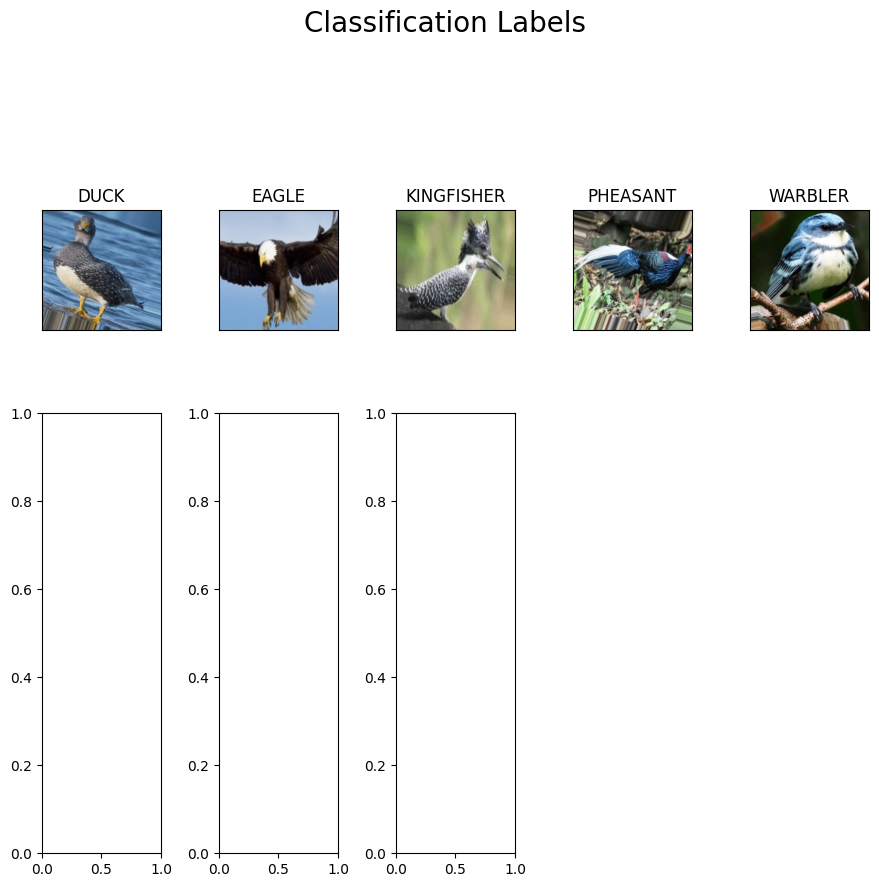

In [356]:
# Grab a batch of images from our validation generator: 
x, y = train_generator.next() 

# Our images labels are one-hot encoded, lets 
# convert them to ordinal encoding
labels = np.argmax(y, axis=1)

# setting the genus names
genus_names = ['DUCK', 'EAGLE', 'KINGFISHER', 'PHEASANT', 'WARBLER']

#set subplot sizes and rows and columns
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(9, 9))

#flatten axis
ax = ax.flatten()

#setting genus names
for i in range(5):
    index = np.argmax(labels==i) 
    ax[i].imshow(x[index])
    
    # Set the title of the subplot
    ax[i].set_title(genus_names[i])
    
    # Hide the x and y ticks
    ax[i].set_xticks([]) 
    ax[i].set_yticks([])
    

fig.suptitle("Classification Labels", size = 20)
fig.tight_layout()

# Delete the two unused subplots
fig.delaxes(ax[-1])
fig.delaxes(ax[-2])

plt.show()

<a id='evaluate_performance_valid'></a>
## Visualization shows diversity of images
The above visualization can be run multiple times to see different instances of birds that fit into their respective genera. This demonstrates the diversity of the images and the difficulty of the task.


<a id='evaluate_performance_test'></a>
## Evaluate the model's performance on the test data

In [357]:
#score the model on test data
score = CNN_model.evaluate(X_test_images, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 1s 105ms/step - loss: 3.6817 - accuracy: 0.3024
Test loss: 3.6816859245300293
Test accuracy: 0.30243903398513794


<a id='base_cnn_conc'></a>
## Base CNN Model Conclusion: 

With 5 relatively equally distributed categories, random guessing would yield an accuracy of 20%. An accuracy of 30% is above this baseline, indicating that the model has learned something from the data and is performing better than random chance. However, it's still not good. 


## Next Steps

Further Image Preprocessing: Denoising, edge detection, background removal could all help improve the quality of image data. 

Data Augmentation: Generating additional training data from my existing examples by augmenting them using transformations could add to the size of my data set and therefore accuracy. 

Hyperparameter Tuning: Adjusting the learning rate, batch size, number of epochs, and other hyperparameters can improve model performance.

Transfer Learning: Utilizing a pre-trained model as a starting point can leverage learned features from a larger, more diverse dataset, potentially improving performance